In [27]:
from __future__ import print_function

import os
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from source.DataFrameSelector import DataFrameSelector

from datetime import datetime, timezone

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.distributions.normal import Normal

In [12]:
DATA_PATH = os.path.join("..", "data")

def load_csv(filename, path=DATA_PATH):
    return pd.read_csv(os.path.join(path, filename))

def to_utc_datetime(df, column="time"):
    df[column] = df.apply(lambda row: datetime.strptime(row[column], "%Y-%m-%d %H:%M:%S%z").astimezone(timezone.utc), axis=1)
    return df

def get_price():
    e_data = load_csv("energy_dataset.csv")
    return e_data[["time", "price day ahead", "total load actual", "price"]].rename(
        columns={"price day ahead": "TSO_price_forecast",
                 "total load actual": "load"})

def add_weather_data(df):
    w_data = load_csv("weather_features.csv").drop(columns=["weather_id", "weather_icon", "temp_min", "temp_max"])
    w_data = w_data.join(other=df.set_index("time"), on="time").drop_duplicates(subset=["time", "city_name"])
    return w_data.reset_index(drop=True)

In [13]:
class TimeSeriesPlot:
    def __init__(self, df: pd.DataFrame, target_col:str, prediction_col:str, time_col:str="time"):
        self.df = df.copy(deep=True)
        self.target = target_col
        self.prediction = prediction_col
        self.time = time_col
        self.df['year'] = self.df[self.time].dt.year
        self.df['month'] = self.df[self.time].dt.month
        self.df['day'] = self.df[self.time].dt.day
        self.df['hours'] = self.df[self.time].dt.hour
        self.df["dayofweek"] = self.df[self.time].dt.weekday
        self.df["se"] = self.squared_error()
        self.df["mae"] = self.absolute_error()
        self.df["mape"] = self.absolute_percentage_error()

    def mape(self):
        return self.df["mape"].mean()

    def mae(self):
        return self.df["mae"].mean()

    def rmse(self):
        return np.sqrt(mean_squared_error(self.df[self.target], self.df[self.prediction]))

    def squared_error(self):
        return np.power(np.subtract(self.df[self.target], self.df[self.prediction]), 2)

    def absolute_error(self):
        return np.abs(np.subtract(self.df[self.target], self.df[self.prediction]))

    def absolute_percentage_error(self):
        return np.abs(np.divide(np.subtract(self.df[self.target], self.df[self.prediction]), self.df[self.target])) * 100

    def plot_rmse_by_time(self, time:str):
        fig = plt.figure()
        col_map = {"y": "year", "m": "month", "d": "day", "h": "hours",  "wd": "dayofweek"}
        group_by_cols = [col_map[param] for param in time.split("%") if param in col_map.keys()]
        grouped = self.df.groupby(by=group_by_cols)
        mean = grouped["se"].mean()
        group_index = [str(index) for index in mean.index]
        plt.plot(group_index, np.sqrt(mean), label="rmse")
        return fig

    def plot_multiple(self, *cols: str):
        fig = plt.figure()
        for col in cols:
            plt.plot(self.df[self.time].values, self.df[col].values, alpha=0.5, label=col)
        plt.legend()
        plt.show()
        return fig

    def plot_target_by_time(self, time:str, *targets:str):
        col_map = {"y": "year", "m": "month", "d": "day", "h": "hours",  "wd": "dayofweek"}
        group_by_cols = [col_map[param] for param in time.split("%") if param in col_map.keys()]
        self.df.boxplot(column=[*targets], by=group_by_cols,
                        layout=(targets.__len__(), 1), rot=45, figsize=(50,40), grid=False)
        return plt.gcf()

    def plot_target_by_time_band(self, time:str, *targets:str, band:bool=True):
        fig = plt.figure()
        col_map = {"y": "year", "m": "month", "d": "day", "h": "hours",  "wd": "dayofweek"}
        group_by_cols = [col_map[param] for param in time.split("%") if param in col_map.keys()]
        grouped = self.df.groupby(by=group_by_cols)
        for tar in targets:
            mean = grouped[tar].mean()
            std = grouped[tar].std()
            group_index = [str(index) for index in mean.index]
            plt.plot(group_index, mean, label=tar)
            if band:
                plt.fill_between(group_index, mean - 2*std, mean + 2*std, alpha=.5)
        plt.legend()
        return fig

In [14]:
data = to_utc_datetime(add_weather_data(get_price()))
data.drop(columns=["weather_main", "weather_description", "TSO_price_forecast"], inplace=True)
data.fillna(method="ffill", inplace=True)
data = data.drop(columns=["city_name"]).groupby(by=["time"]).mean()

In [15]:
target_column = "price"
#features = ["temp", "pressure", "humidity", "wind_speed", "wind_deg", "rain_1h", "rain_3h", "snow_3h", "clouds_all", "load", "price"]
features = ["price"]
num_features = len(features)
data = data.loc[:, features]

In [16]:
target_year = 2018

train_data = data.loc[data.index.year < target_year]
test_data = data.loc[data.index.year == target_year]

In [17]:
scaler_y = MinMaxScaler()
scaler_y.fit(train_data[target_column].values.reshape(-1, 1))

scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#train_data_scaled = torch.FloatTensor(train_data_scaled).to(device)

In [18]:
def create_input_output_sequence(input_data, seq_len, pred_len=1, multivar=False):
    # if multivar: target column has to be the last column
    X = []
    y = []
    for i in range(len(input_data) - seq_len - pred_len + 1):
        train_seq = input_data[i:i+seq_len]
        train_label = input_data[i+seq_len:i+seq_len+pred_len]
        if not multivar:
            train_label = train_label[:, -1]
        X.append(train_seq)
        y.append(train_label)
    X=torch.FloatTensor(X).to(device)
    y=torch.FloatTensor(y).to(device)
    return X, y

seq_len = 48 #24*7
out_seq_len = 24
X, y = create_input_output_sequence(train_data_scaled, seq_len, out_seq_len)

In [10]:
# x has values from a to b, y has values from b+1 to c, so x+y should be equal to the a-c sclice of train_data_scaled
assert np.sum(np.concatenate((X.cpu().numpy()[0, -4:].flatten(), y.cpu().numpy()[0, :4].flatten()))
              - torch.FloatTensor(train_data_scaled[44:52].flatten()).numpy()) == 0

In [19]:
def split_validation(X, y, num_val):
    idx = np.random.choice(X.shape[0], num_val, replace=False)
    mask = np.ones(X.shape[0], bool)
    mask[idx] = False
    return X[mask], y[mask], X[idx], y[idx]

X, y, X_val, y_val = split_validation(X, y, 300)

In [153]:
X.shape

torch.Size([25514, 168, 11])

In [12]:
class D_LSTM_Seq(nn.Module):
    def __init__(self, input_dim, out_seq_len=1, hidden_dim=100, layer_dim=1, output_dim=1):
        super(D_LSTM_Seq, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.out_seq_len = out_seq_len
        self.lstm_in = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.lstm_repeat = nn.LSTM(hidden_dim, hidden_dim, layer_dim, batch_first=True)
        # self.lstm_repeat = nn.LSTM(1, hidden_dim, layer_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def init_hidden_cell(self, batch_size):
        return (torch.zeros(self.layer_dim, batch_size, self.hidden_dim).to(device),
                torch.zeros(self.layer_dim, batch_size, self.hidden_dim).to(device))

    def lstm_wrapper(self, batch):
        _, (x, _) = self.lstm_repeat(batch, self.init_hidden_cell(batch.shape[0]))
        return x[-1] # last layer

    def forward(self, x):
        batch_size = x.shape[0]
        x, (_, _) = self.lstm_in(x, self.init_hidden_cell(batch_size))
        # x.shape = [batch, seq_len, hidden_dim] = [batch, timesteps t, h(t)]
        x = x.unsqueeze(1).repeat(1, self.out_seq_len, 1, 1)
        # x.shape = [batch, out_seq_len repeats of batch, seq_len, hiddem_dim]
        # so we can get batch_size batches instead of out_seq_len sized ones
        x = x.view(self.out_seq_len, batch_size, -1, self.hidden_dim)
        # x.shape = [out_seq_len repeats of batch, batch, seq_len, hiddem_dim]
        x = torch.cat([self.lstm_wrapper(batch) for batch in x])
        # x.shape = [batch * out_seq_len, hidden_dim]
        x = self.linear(x)
        # x.shape = [batch * out_seq_len, output_dim]
        # order output back into out_seq_len size
        x = x.view(batch_size, self.out_seq_len, -1)
        if x.shape[-1] == 1:
            x = x.view(x.shape[0], -1) # if output_dim = 1, merge last two dimensions
        return x

class LSTMSeq2SeqOle(nn.Module):
    def __init__(self, input_dim, out_seq_len=1, hidden_dim=100, layer_dim=1, output_dim=1):
        super(LSTMSeq2SeqOle, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.out_seq_len = out_seq_len
        self.lstm_in = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.lstm_repeat = nn.LSTM(hidden_dim, hidden_dim, layer_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        Input is encoded by lstm_in
        Output of lstm_in is the input of lstm_repeat; lstm_repeat starts with new empty states (h,c)
        Output of lstm_in is repeated out_seq_len times to get out_seq_len long sequences
        """
        # encode
        _, (x, _) = self.lstm_in(x) # x.shape = [lstm_layer, batch, hidden_dim]
        x = x[-1] # last lstm_layer; x.shape = [batch, hidden_dim]
        x = x.unsqueeze(1).repeat(1, self.out_seq_len, 1) # x.shape = [batch, out_seq_len, hiddem_dim]

        # decode
        x, (_, _) = self.lstm_repeat(x) # x.shape = [batch, out_seq_len, hidden_dim]
        x = self.linear(x) # x.shape = [batch, out_seq_len, output_dim]
        if x.shape[-1] == 1:
            x = x.view(x.shape[0], -1) # if output_dim = 1, merge last two dimensions
        return x

class LSTMSeq2SeqBook(nn.Module):
    def __init__(self, input_dim, out_seq_len=1, hidden_dim=100, layer_dim=1, output_dim=1):
        super(LSTMSeq2SeqBook, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.out_seq_len = out_seq_len
        self.lstm_in = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.lstm_repeat = nn.LSTM(1, hidden_dim, layer_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        Input is encoded by lstm_in
        Output of lstm_in is the starting state for lstm_repeat (h, c)
        Input for lstm_repeat is zero ([batch, out_seq_len, 1])
        """
        # encode
        _, (h, c) = self.lstm_in(x)
        # decode
        x, (_, _) = self.lstm_repeat(torch.zeros(x.shape[0], self.out_seq_len, 1).to(device), (h, c)) # x.shape = [batch, out_seq_len, hidden_dim]
        x = self.linear(x) # x.shape = [batch, out_seq_len, output_dim]
        if x.shape[-1] == 1:
            x = x.view(x.shape[0], -1) # if output_dim = 1, merge last two dimensions
        return x

class LSTMSeq2SeqBookTranslation(nn.Module):
    def __init__(self, input_dim, out_seq_len=1, hidden_dim=100, layer_dim=1, output_dim=1):
        super(LSTMSeq2SeqBookTranslation, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.out_seq_len = out_seq_len
        self.lstm_in = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.lstm_repeat = nn.LSTM(1, hidden_dim, layer_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x, y=None):
        """
        During training y must be the correct labels. After training y must be None
        Input is encoded by lstm_in
        Output of lstm_in is the starting state for lstm_repeat (h, c)
        Input for lstm_repeat during training:
            the labels shifted by one (timestep x gets the correct value of timestep x-1)
            last label is discarded, first label is zero
        Input for lstm_repeat after training:
            Output of lstm_repeat at timestep x-1 is the input for timestep x
            in this case: output is a vector but input must be len 1, thus the output at timestep x-1 is used for a linear layer first
        """
        # encode
        _, (h, c) = self.lstm_in(x)
        # decode
        if y is not None:
            decoder_input = y.unsqueeze(-1).roll(1, dims=1)
            decoder_input[:, 0] = 0
            x, (_, _) = self.lstm_repeat(decoder_input, (h, c))
            x = self.linear(x)
        else:
            # seq_len per input must be 1 since we feed the seq manually
            # feature is the output of the last iteration, zero for first
            decoder_input = torch.zeros(x.shape[0], 1, 1).to(device)
            # out_seq_len, batch, output
            x = torch.zeros(self.out_seq_len, x.shape[0], 1).to(device)
            for i in range(self.out_seq_len):
                _, (h, c) = self.lstm_repeat(decoder_input, (h, c))
                x[i] = self.linear(h[-1]) # h[-1] = last layer
                decoder_input = x[i].unsqueeze(1) # unsqueeze to add seq_len 1
            # x.shape = [out_seq_len, batch, 1]
            x = x.transpose(0, 1) # batch first
        # x.shape = [batch, out_seq_len, output_dim]
        if x.shape[-1] == 1:
            x = x.view(x.shape[0], -1) # if output_dim = 1, merge last two dimensions
        return x

class LSTMSeq2SeqDistribution(nn.Module):
    def __init__(self, input_dim, out_seq_len=1, hidden_dim=100, layer_dim=1, output_dim=1):
        super(LSTMSeq2SeqDistribution, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.out_seq_len = out_seq_len
        self.lstm_in = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.linear_mu = nn.Linear(hidden_dim, hidden_dim)
        self.linear_log_std = nn.Linear(hidden_dim, hidden_dim)
        self.lstm_repeat = nn.LSTM(hidden_dim, hidden_dim, layer_dim, batch_first=True)
        self.linear_output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        Input is encoded by lstm_in
        Output of lstm_in is the input of lstm_repeat; lstm_repeat starts with new empty states (h,c)
        Output of lstm_in is repeated out_seq_len times to get out_seq_len long sequences
        """
        # encode
        _, (x, _) = self.lstm_in(x) # x.shape = [lstm_layer, batch, hidden_dim]
        x = x[-1] # last lstm_layer; x.shape = [batch, hidden_dim]
        mu = self.linear_mu(x)
        log_std = self.linear_log_std(x)
        dist = Normal(mu, np.exp(torch.clamp(log_std, -8, 8)))
        x = dist.rsample(x.shape[0])
        # decode
        x, (_, _) = self.lstm_repeat(x) # x.shape = [batch, out_seq_len, hidden_dim]
        x = self.linear(x) # x.shape = [batch, out_seq_len, output_dim]
        if x.shape[-1] == 1:
            x = x.view(x.shape[0], -1) # if output_dim = 1, merge last two dimensions
        return x

In [10]:
mini_batch = 100
model = LSTMSeq2SeqOle(input_dim=num_features, out_seq_len=out_seq_len, hidden_dim=84)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)

LSTMSeq2SeqOle(
  (lstm_in): LSTM(1, 84, batch_first=True)
  (lstm_repeat): LSTM(84, 84, batch_first=True)
  (linear): Linear(in_features=84, out_features=1, bias=True)
)

In [11]:
val_loss_hist = []
last_val_scores = []
max_val_scores = 4

epochs = 10000
for i in tqdm(range(epochs)):
    # train
    idx = np.random.choice(X.shape[0], mini_batch, replace=False)
    optimizer.zero_grad()
    #model.hidden_cell = (torch.zeros(2, mini_batch, model.hidden_layer_size).to(device),torch.zeros(2, mini_batch, model.hidden_layer_size).to(device))
    y_pred = model(X[idx])
    single_loss = loss(y_pred, y[idx])
    single_loss.backward()
    optimizer.step()

    # validation
    #idx = np.random.choice(X_val.shape[0], mini_batch, replace=False)
    #y_pred = model(X_val[idx])
    #val_loss = loss(y_pred, y_val[idx]).detach().cpu().numpy().tolist()
    #if len(last_val_scores) >= max_val_scores:
    #    if val_loss > max(last_val_scores):
    #        pass
    #last_val_scores.append(val_loss)
    #last_val_scores = last_val_scores[-4:]
    #val_loss_hist.append(val_loss)

    if i%500 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

100%|██████████| 10000/10000 [02:03<00:00, 81.21it/s]


epoch:   0 loss: 0.20100304
epoch: 500 loss: 0.00754089
epoch: 1000 loss: 0.00813984
epoch: 1500 loss: 0.00917924
epoch: 2000 loss: 0.00715278
epoch: 2500 loss: 0.00534219
epoch: 3000 loss: 0.00461956
epoch: 3500 loss: 0.00378262
epoch: 4000 loss: 0.00446807
epoch: 4500 loss: 0.00314234
epoch: 5000 loss: 0.00430210
epoch: 5500 loss: 0.00369389
epoch: 6000 loss: 0.00316687
epoch: 6500 loss: 0.00270783
epoch: 7000 loss: 0.00307925
epoch: 7500 loss: 0.00356605
epoch: 8000 loss: 0.00331345
epoch: 8500 loss: 0.00347000
epoch: 9000 loss: 0.00451520
epoch: 9500 loss: 0.00285527
epoch: 9999 loss: 0.0034507688


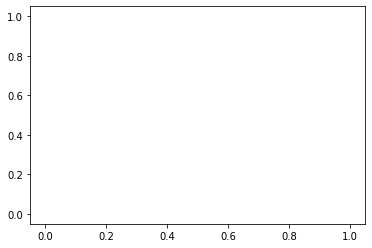

In [113]:
plt.plot(val_loss_hist)

In [20]:
test_data_scaled = scaler.transform(test_data)

In [13]:
pred_len = int(len(test_data) / out_seq_len) * out_seq_len
test_inputs = np.vstack((train_data_scaled[-seq_len:].tolist(), test_data_scaled)).tolist()
prediction = []
for i in tqdm(range(0, pred_len, out_seq_len)):
    seq = torch.FloatTensor([test_inputs[i+j:i+j+seq_len] for j in range(out_seq_len)]).to(device)
    with torch.no_grad():
        output = model(seq)
        prediction.append(output.cpu().numpy())

prediction = np.array(prediction).reshape(-1, out_seq_len)
#prediction_df = test_data[:prediction.shape[0]].assign(prediction=scaler_y.inverse_transform(prediction.reshape(-1, 1)).reshape(-1)).reset_index()

100%|██████████| 364/364 [00:00<00:00, 506.42it/s]


In [14]:
f_o=23 # offset into the future: 0 next hour, 1 predeciton of next hour +1
prediction_df = test_data[f_o:prediction.shape[0]+f_o].assign(prediction=scaler_y.inverse_transform(prediction[:,f_o].reshape(-1, 1)).reshape(-1)).reset_index()
#prediction_df = test_data[f_o:prediction.shape[0]+f_o].assign(prediction=prediction[:,f_o]).reset_index()


In [15]:
foobar = TimeSeriesPlot(prediction_df, "price", "prediction")
fig = foobar.plot_multiple("price", "prediction")
fig.savefig("../results/seq_forecast_%d.png" % (f_o + 1))
#bp = foobar.plot_target_by_time("%m%wd", "price", "prediction")
#bp.savefig("results/foo.png")
#band = foobar.plot_target_by_time_band("%m", "mape", band=False)
#band.savefig("results/mape_per_month.png")
#band = foobar.plot_target_by_time_band("%h", "mape", band=False)
#band.savefig("results/mape_per_hour.png")
#band = foobar.plot_target_by_time_band("%m", "mae", band=False)
#band.savefig("results/mae_per_hour.png")
#rmse = foobar.plot_rmse_by_time("%m")
#band.savefig("results/band.png")

NameError: name 'TimeSeriesPlot' is not defined

In [109]:
print("rmse: %f" % foobar.rmse())
print("mape: %f" % foobar.mape())
print("mae: %f" % foobar.mae())

rmse: 7.475326
mape: 10.895744
mae: 5.713028


In [40]:
stats = []
for f_o in tqdm(range(24)):
    prediction_df = test_data[f_o:prediction.shape[0]+f_o].assign(prediction=scaler_y.inverse_transform(prediction[:,f_o].reshape(-1, 1)).reshape(-1)).reset_index()
    #prediction_df = test_data[f_o:prediction.shape[0]+f_o].assign(prediction=prediction[:,f_o]).reset_index()
    foobar = TimeSeriesPlot(prediction_df, "price", "prediction")
    stats.append([foobar.rmse(), foobar.mape(), foobar.mae()])
df_stats = pd.DataFrame(stats, columns=["rmse", "mape", "mae"])
df_stats

100%|██████████| 24/24 [00:00<00:00, 30.11it/s]


,rmse,mape,mae
0,2.741979,3.551989,2.002144
1,3.984008,5.354510,3.060313
2,4.709319,6.373457,3.606989
3,5.326913,7.309291,4.141443
4,5.739992,7.946576,4.488469
5,6.045199,8.410683,4.726461
6,6.283644,8.788094,4.925267
7,6.489901,9.111899,5.101034
8,6.683635,9.435485,5.274937
9,6.864154,9.726051,5.434986


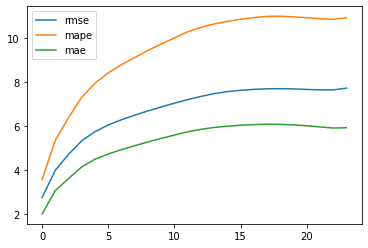

In [41]:
t = df_stats.plot()
#t.get_figure().savefig("../results/seq2seq_forecast_24h_book.png")

In [ ]:
prediction = np.loadtxt(os.path.join(DATA_PATH, "predictions_inversed.csv"))
#np.savetxt(os.path.join(DATA_PATH, "predictions_inversed.csv"), prediction)

In [21]:
#np.save(os.path.join(DATA_PATH, "x_embedded"), X_embedded)
#sal = np.load(os.path.join(DATA_PATH, "saliency_feature_ole.npy"))
X_embedded = np.load(os.path.join(DATA_PATH, "x_embedded.npy"))
prediction = np.load(os.path.join(DATA_PATH, "prediction_ole_numfeatures=1.npy"))

In [93]:
def sum_abs_diff_batch(a, b):
    return np.sum(np.abs(a-b), 1)

test_inputs = np.vstack((train_data_scaled[-seq_len:].tolist(), test_data_scaled)).tolist()
mini_batch = 100
batch_count = int(len(test_data) / mini_batch) * mini_batch
prediction = np.empty((int(batch_count/mini_batch), mini_batch, seq_len))
mask = torch.zeros(num_features).to(device)

with torch.no_grad():
    for batch, i in enumerate(tqdm(range(0, batch_count, mini_batch))):
        seq = torch.FloatTensor([test_inputs[i+j:i+j+seq_len] for j in range(mini_batch)]).to(device)
        pred = model(seq).cpu().numpy() # pred.shape = [batch, 24]
        pred_ = np.empty((seq_len, mini_batch, out_seq_len))
        for j in range(seq_len):
            feature_vector_batch = seq[:, j].clone()
            seq[:, j] = mask
            pred_[j] = model(seq).cpu().numpy()
            seq[:, j] = feature_vector_batch
        prediction[batch] = np.array([sum_abs_diff_batch(pred, p) for p in pred_]).swapaxes(0, 1)

sal = prediction.reshape(-1, seq_len)

100%|██████████| 87/87 [01:00<00:00,  1.44it/s]


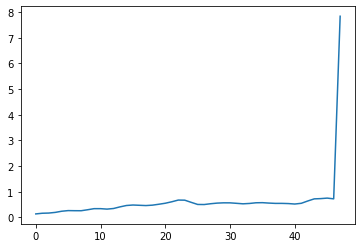

In [94]:
plt.plot(np.mean(sal, axis=0))

In [104]:
def sum_abs_diff_batch(a, b):
    return np.sum(np.abs(a-b), 1)

mini_batch = 100

test_inputs = np.vstack((train_data_scaled[-seq_len:].tolist(), test_data_scaled)).tolist()
batch_count = int(len(test_data) / mini_batch) * mini_batch
prediction = np.empty((int(batch_count / mini_batch), mini_batch, seq_len, num_features))
mask_mat = (torch.eye(num_features) - torch.ones(num_features)).abs().to(device)

with torch.no_grad():
    for batch, i in enumerate(tqdm(range(0, batch_count, mini_batch))):
        seq = torch.FloatTensor([test_inputs[i+j:i+j+seq_len] for j in range(mini_batch)]).to(device)
        pred = model(seq).cpu().numpy()
        pred_ = np.empty((seq_len, num_features, mini_batch, out_seq_len))
        for j in range(seq_len):
            feature_vector_batch = seq[:, j].clone()
            for k in range(num_features):
                seq[:, j] = feature_vector_batch * mask_mat[k]
                pred_[j, k] = model(seq).cpu().numpy()
                seq[:, j] = feature_vector_batch
        prediction[batch] = np.array([[sum_abs_diff_batch(pred, f) for f in s] for s in pred_]).transpose((2, 0, 1))

sal = prediction.reshape(-1, seq_len, num_features)

100%|██████████| 87/87 [00:15<00:00,  5.58it/s]


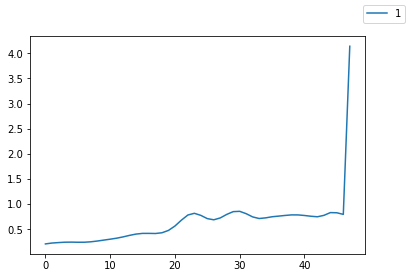

In [105]:
for i in range(0, num_features):
    plt.plot(np.mean(sal[:,:,i], axis=0), label=i+1)

plt.gcf().legend()

In [23]:
test_inputs, _ = create_input_output_sequence(np.vstack((train_data_scaled[-seq_len:].tolist(), test_data_scaled)), seq_len, out_seq_len)

In [22]:
mini_batch = 100
batch_count = int(test_inputs.shape[0] / mini_batch) * mini_batch
lstm = model.lstm_in

states = []
with torch.no_grad():
    for batch, i in enumerate(tqdm(range(0, batch_count, mini_batch))):
        _, (h, _) = lstm(test_inputs[i:i+mini_batch])
        states.append(h[-1].cpu().numpy()) # h[-1] last layer
states = np.array(states).reshape(-1, model.hidden_dim)

100%|██████████| 87/87 [00:00<00:00, 537.21it/s]


In [25]:
X_embedded = TSNE(n_components=2, verbose=1, n_jobs=-1, perplexity=10).fit_transform(states)

NameError: name 'states' is not defined

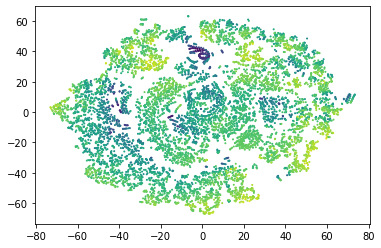

In [26]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=prediction[:X_embedded.shape[0], 0], s=1)
plt.viridis()

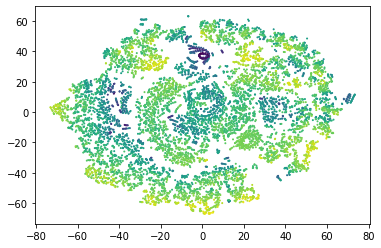

In [26]:
weights = np.ones(48)
weights[-1] = 48
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=np.average(test_inputs[:X_embedded.shape[0]].reshape(-1, 48), axis=1, weights=weights), s=1)
plt.viridis()